# This code demonstrates the classification of the given news as fake or true.<br>
Method : LSTM deep learning model is used for the classification.<br>
Dataset: labelled dataset namely, "fake.csv" and "True.csv"<br>    

In [11]:
#for data analysis and modeling
import tensorflow as tf
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout
from tensorflow.keras.preprocessing import text, sequence 
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
#for text cleaning
import string
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
#for visualization
import matplotlib.pyplot as plt

## Importing Necessary Libraries

### Reading the dataframes

In [12]:
true = pd.read_csv('True.csv')
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [13]:
fake = pd.read_csv('Fake.csv')
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


### Concatinating the data into a single dataframe and adding a column to categorize the same

In [14]:
true['truth'] = 1
fake['truth'] = 0
df = pd.concat([true, fake], axis=0, ignore_index=True)
df.shape

(44898, 5)

In [15]:
df

,title,text,subject,date,truth
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1
...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",0
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",0
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",0
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",0


E:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
<ipython-input-16-98f87c291f1d>:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


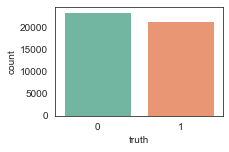

In [16]:
#Checking balance and imbalance data
import seaborn as sns
sns.set_style("white")
sns.set_palette('Set2')
fig, ax=plt.subplots(figsize=(3, 2))
ax = sns.countplot(df.truth)
fig.show()

### Cleanig the data
####    1- replace contractions
####    2- removing punctuation
####    3- spliting into words
####    4- removing stopwords
####    5- removing leftover punctuations

In [17]:
%%time
def clean_text(txt):
    contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", 
                        "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", 
                        "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", 
                        "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  
                        "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", 
                        "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have",
                        "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
                        "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", 
                        "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
                        "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", 
                        "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", 
                        "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                        "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
                        "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", 
                        "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have",
                        "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", 
                        "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", 
                        "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                        "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", 
                        "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": 
                        "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", 
                        "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", 
                        "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", 
                        "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", 
                        "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                        "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", 
                        "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", 
                        "you've": "you have"}
    def _get_contractions(contraction_dict):
        contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
        return contraction_dict, contraction_re

    def replace_contractions(text):
        contractions, contractions_re = _get_contractions(contraction_dict)
        def replace(match):
            return contractions[match.group(0)]
        return contractions_re.sub(replace, text)

    # replace contractions
    txt = replace_contractions(txt)
    
    #remove punctuations
    txt  = "".join([char for char in txt if char not in string.punctuation])
    txt = re.sub('[0-9]+', '', txt)
      # split into words
    words = word_tokenize(txt)
    
    # remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    
    # removing leftover punctuations
    words = [word for word in words if word.isalpha()]
    
    cleaned_text = ' '.join(words)
    return cleaned_text
    
df['data_cleaned'] = df['title'].apply(lambda txt: clean_text(txt))

Wall time: 24.1 s


In [18]:
df['data_cleaned']

0        As US budget fight looms Republicans flip fisc...
1        US military accept transgender recruits Monday...
2          Senior US Republican senator Let Mr Mueller job
3        FBI Russia probe helped Australian diplomat ti...
4        Trump wants Postal Service charge much Amazon ...
                               ...                        
44893    McPain John McCain Furious That Iran Treated U...
44894    JUSTICE Yahoo Settles Email Privacy Classactio...
44895    Sunnistan US Allied Safe Zone Plan Take Territ...
44896    How Blow Million Al Jazeera America Finally Ca...
44897    US Navy Sailors Held Iranian Military Signs Ne...
Name: data_cleaned, Length: 44898, dtype: object

In [19]:
df.head()

,title,text,subject,date,truth,data_cleaned
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1,As US budget fight looms Republicans flip fisc...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1,US military accept transgender recruits Monday...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1,Senior US Republican senator Let Mr Mueller job
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1,FBI Russia probe helped Australian diplomat ti...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1,Trump wants Postal Service charge much Amazon ...


## Preparing the data for testing and training

In [20]:
xtrain, xtest, ytrain, ytest = train_test_split(df['data_cleaned'], df['truth'], shuffle=True, test_size=0.2)
# find the length of the largest sentence in training data
max_len = xtrain.apply(lambda x: len(x)).max()
print(f'Max number of words in a text in training data: {max_len}')

Max number of words in a text in training data: 227


In [21]:
xtrain

16461    On Shanghai outskirts residents unmoved China ...
5049     Senators ask US paying secure Trump property o...
25660    President Obama To GOP Decent Human Beings Wou...
14123    Mladic verdict carries message Syria beyond UN...
38537    WATCH JOHN KERRY S FEAR MONGERING ON IRAN DEAL...
                               ...                        
25068    Clinton Team Takes Aim At Trump For His FullBl...
16199    Poland wants strong euro zone mulling membersh...
30660    JUST IN MUELLER S Right Hand Man Represented I...
30982    TOLD TO SURRENDER Former Trump Campaign Manage...
15163    UN urges calm deadline nears asylum seekers qu...
Name: data_cleaned, Length: 35918, dtype: object

In [22]:
ytrain

16461    1
5049     1
25660    0
14123    1
38537    0
        ..
25068    0
16199    1
30660    0
30982    0
15163    1
Name: truth, Length: 35918, dtype: int64

In [23]:
xtest

8780     House panel subpoenas New York Massachusetts a...
23611    UNHINGED White Male GOP Rep Makes COMPLETELY O...
35849    CUCKOO BERNIE SANDERS SUPPORTER Gets Hammered ...
25150    Fox News To Black Hamilton Actor Shut Up And S...
8027     Canada works counter protectionist mood US cam...
                               ...                        
12728    Head Zimbabwe election commission quits source...
26303    WV Republican AG Spokeswoman BUSTED Appearing ...
21527    Alabama Republican Just Defended Pedophilia Us...
4856         In talks US China calls diplomacy North Korea
23565    Trump Just Had The Most AWKWARD Moment With Sa...
Name: data_cleaned, Length: 8980, dtype: object

## Tokenize the input training sentences
### fit_on_texts: We'll fit the tokenizer on our training data to create the word indices
### texts_to_sequences: using the word index dictionary from step above, we take this step to transform both train and test data.
## Truncating and padding the input sequences.
### Training the model to learn that the zero values carry no information. Hence, the sequences are not the same length in terms of content. But same length vectors is required to perform the computation in Keras. So we select the words appropriately

In [24]:
max_words = 10000
tokenizer = text.Tokenizer(num_words = max_words)
# create the vocabulary by fitting on x_train text
tokenizer.fit_on_texts(xtrain)
# generate the sequence of tokens
xtrain_seq = tokenizer.texts_to_sequences(xtrain)
xtest_seq = tokenizer.texts_to_sequences(xtest)

# pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xtest_pad = sequence.pad_sequences(xtest_seq, maxlen=max_len)
word_index = tokenizer.word_index

print('text example:', xtrain)

print('sequence of indices(before padding):', xtrain_seq[0])
print('sequence of indices(after padding):', xtrain_pad[0])


text example: 16461    On Shanghai outskirts residents unmoved China ...
5049     Senators ask US paying secure Trump property o...
25660    President Obama To GOP Decent Human Beings Wou...
14123    Mladic verdict carries message Syria beyond UN...
38537    WATCH JOHN KERRY S FEAR MONGERING ON IRAN DEAL...
                               ...                        
25068    Clinton Team Takes Aim At Trump For His FullBl...
16199    Poland wants strong euro zone mulling membersh...
30660    JUST IN MUELLER S Right Hand Man Represented I...
30982    TOLD TO SURRENDER Former Trump Campaign Manage...
15163    UN urges calm deadline nears asylum seekers qu...
Name: data_cleaned, Length: 35918, dtype: object
sequence of indices(before padding): [10, 8903, 1243, 8904, 77, 2240, 1266]
sequence of indices(after padding): [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    

In [25]:
print(len(xtrain_pad[0]))

227


In [26]:
xtrain_pad.shape

(35918, 227)

In [27]:
vocab_len = len(word_index)+1
print(vocab_len)

20953


In [28]:
print(word_index)

{'trump': 1, 'video': 2, 'to': 3, 'the': 4, 'us': 5, 'for': 6, 'of': 7, 'in': 8, 'says': 9, 'on': 10, 'a': 11, 'obama': 12, 'and': 13, 'is': 14, 'with': 15, 'hillary': 16, 'house': 17, 'watch': 18, 'new': 19, 'clinton': 20, 'about': 21, 'white': 22, 'after': 23, 'his': 24, 'president': 25, 'he': 26, 'it': 27, 'just': 28, 'at': 29, 's': 30, 'bill': 31, 'by': 32, 'from': 33, 'this': 34, 'who': 35, 'russia': 36, 'state': 37, 'republican': 38, 'north': 39, 'you': 40, 'court': 41, 'out': 42, 'news': 43, 'over': 44, 'as': 45, 'senate': 46, 'that': 47, 'black': 48, 'election': 49, 'her': 50, 'korea': 51, 'are': 52, 'donald': 53, 'will': 54, 'breaking': 55, 'media': 56, 'why': 57, 'how': 58, 'not': 59, 'him': 60, 'vote': 61, 'be': 62, 'calls': 63, 'gop': 64, 'was': 65, 'republicans': 66, 'police': 67, 'tax': 68, 'up': 69, 'campaign': 70, 'deal': 71, 'what': 72, 'america': 73, 'may': 74, 'muslim': 75, 'one': 76, 'china': 77, 'trumps': 78, 'i': 79, 'has': 80, 'russian': 81, 'democrats': 82, 'ira

In [29]:
print(xtest_seq)

[[17, 266, 3871, 19, 362, 3650, 4146, 269], [1162, 22, 2428, 64, 504, 149, 1759, 622, 21, 58, 972, 141], [181, 135, 239, 85, 3322, 32, 2], [120, 43, 3, 48, 3450, 1080, 529, 69, 13, 2832, 3, 7632, 2], [720, 1928, 2786, 7336, 5, 70], [19, 1710, 2694, 109, 9, 1428, 4099, 99, 212, 1651, 573], [23, 87, 1889, 36, 1049, 1886, 731, 1315], [1134, 500, 1, 689, 348, 20], [18, 144, 638, 325, 507, 9707, 7389, 290, 278, 26, 65, 48], [55, 4, 148, 41, 307, 107, 4, 664, 10, 474, 3143, 2306], [5, 1204, 732, 3785, 1079, 9, 93, 154], [5, 232, 451, 792, 2721, 307, 5306, 3391], [202, 8745, 2474, 4525, 1141, 4105, 2459, 122, 9], [1, 19, 431, 6, 3382, 4, 64, 627, 26, 2631, 3, 58, 684, 348, 187], [19, 4060, 9, 193, 430, 195], [22, 17, 3605, 1725, 855, 19, 2512, 676, 138], [465, 89, 1015, 1533, 3765, 80, 11, 19, 5716, 6, 133, 1181, 27, 683], [23, 6426, 30, 984, 5184, 13, 387, 8, 355, 327, 8, 77, 2], [548, 66, 1406, 44, 1, 229, 4, 1656, 431, 57, 567], [1, 28, 1610, 3, 1234, 8, 4, 1155, 3, 621, 10, 12, 4040, 90],

In [30]:
print(xtrain_seq[0])

[10, 8903, 1243, 8904, 77, 2240, 1266]


## Word Embedding with the pre trained GloVe Vector

In [43]:
import numpy as np

embedding_vectors = {}
# with open('glove.6B.100d.txt','r',encoding='utf-8') as file:
with open('glove.6B.100d.txt','r',encoding='utf-8') as file:
    for row in file:
        values = row.split(' ')
        word = values[0]
        weights = np.asarray([float(val) for val in values[1:]])
        embedding_vectors[word] = weights
print(f"Size of vocabulary in GloVe: {len(embedding_vectors)}")   

print(embedding_vectors)
'''
import gensim
from gensim.models import Word2Vec

word2vec = Word2Vec(xtrain_seq, min_count=2)
vocabulary = word2vec.wv.vectors
print(vocabulary)
'''

Size of vocabulary in GloVe: 400000


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



'\nimport gensim\nfrom gensim.models import Word2Vec\n\nword2vec = Word2Vec(xtrain_seq, min_count=2)\nvocabulary = word2vec.wv.vectors\nprint(vocabulary)\n'

## Create an embedding matrix with the GloVe vectors
### The embedding matrix has a shape of (vocabulary length, embedding dimension).

In [44]:
#initialize the embedding_matrix with zeros
emb_dim = 100
if max_words is not None: 
    vocab_len = max_words 
else:
    vocab_len = len(word_index)+1
embedding_matrix = np.zeros((vocab_len, emb_dim))
oov_count = 0
oov_words = []
for word, idx in word_index.items():
    if idx < vocab_len:
        embedding_vector = embedding_vectors.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector
        else:
            oov_count += 1 
            oov_words.append(word)
#print some of the out of vocabulary words
print(f'Some out of valubulary words: {oov_words[0:5]}')


Some out of valubulary words: ['brexit', 'antitrump', 'antifa', 'zimbabwes', 'reutersipsos']
10000


In [45]:
print(vocab_len)

10000


In [46]:
max_words


10000

In [47]:
embedding_vector

array([-0.75513  ,  0.4073   ,  0.91001  ,  0.80476  ,  0.44273  ,
       -0.31567  ,  0.45636  , -0.31391  ,  0.61847  ,  0.28168  ,
       -1.0655   , -0.0344   , -0.17584  ,  0.88839  , -0.84728  ,
        0.038639 , -0.14825  , -1.1252   , -0.84378  , -0.53498  ,
       -0.27612  ,  0.53295  ,  0.15999  ,  0.32568  ,  0.11608  ,
       -0.1191   , -0.074062 ,  0.55454  ,  0.61607  , -0.24284  ,
        0.12988  , -0.78759  , -0.51388  , -0.43707  ,  0.39608  ,
       -0.15616  ,  1.1712   ,  0.080468 ,  0.5151   , -0.42999  ,
       -0.97877  , -0.019188 ,  0.27545  , -0.27231  ,  0.028884 ,
       -0.19584  ,  0.94479  , -0.6874   , -0.19573  , -0.52001  ,
        0.32551  ,  0.72328  , -0.7904   ,  0.80239  ,  0.0034524,
       -1.0806   , -0.070831 , -0.0527   ,  0.38003  ,  0.55034  ,
        0.097581 ,  1.0802   ,  0.16363  , -0.54164  ,  0.5577   ,
       -0.52561  , -0.42247  ,  0.24367  ,  0.023775 , -0.08872  ,
        0.80129  , -1.1936   , -0.5381   ,  0.088305 ,  0.5252

In [51]:
embedding_matrix

array([[ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [-0.15731  , -0.75503  ,  0.36845  , ..., -0.54137  ,  0.67817  ,
        -0.17251  ],
       [ 0.10034  , -0.38489  ,  0.24913  , ..., -0.11584  ,  1.1675   ,
        -0.063932 ],
       ...,
       [-0.64377  ,  0.22444  , -0.14567  , ..., -0.30388  ,  0.0019616,
         0.15552  ],
       [ 0.25451  ,  0.58938  , -0.15101  , ..., -0.10575  , -0.30655  ,
        -0.19004  ],
       [-0.75513  ,  0.4073   ,  0.91001  , ...,  0.96562  , -0.15477  ,
         0.88492  ]])

In [49]:
emb_dim

100

### Note : If a word in our word_index is not found in the embedding vectors from GloVe. The weight of that word remains as zero.

In [33]:
print(f'{oov_count} out of {vocab_len} words were OOV.')

376 out of 10000 words were OOV.


# (Deep) LSTM model

### >First Layer -  Embedding layer that uses Vocabulary size of the GloVe vextor as length vectors to represent each word
### >Second Layer - LSTM layer with 128 memory units ], return_sequence disabled to return the output.
#### >Second Layer (For deep LSTM) - LSTM layer with 128 memory units, return_sequence enabled to be fed into the following LSTM Layer. 
### Third Layer - Dropout Layer for Regularization
### >Fourth Layer -  Dense output layer with a single neuron and a sigmoid activation function to make 0 or 1 predictions for the two classes.
### >Compilation Layer with loss function as 'binary_crossentropy' to classify the outputs into one of the two classes and optimizer as 'adam'.

In [35]:
lstm_model = Sequential()
lstm_model.add(Embedding(vocab_len, emb_dim, trainable = False, weights=[embedding_matrix]))
lstm_model.add(LSTM(128, return_sequences=False))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(1, activation = 'sigmoid'))
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(lstm_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 100)         1000000   
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,117,377
Trainable params: 117,377
Non-trainable params: 1,000,000
_________________________________________________________________
None


In [36]:
%%time
batch_size = 256
epochs  = 10
history = lstm_model.fit(xtrain_pad, np.asarray(ytrain), validation_data=(xtest_pad, np.asarray(ytest)), batch_size = batch_size, epochs = epochs)

Epoch 1/10
141/141 [==============================] - 148s 980ms/step - loss: 0.1495 - accuracy: 0.9431 - val_loss: 0.0986 - val_accuracy: 0.9637
Epoch 2/10
141/141 [==============================] - 143s 1s/step - loss: 0.0875 - accuracy: 0.9683 - val_loss: 0.0789 - val_accuracy: 0.9715
Epoch 3/10
141/141 [==============================] - 143s 1s/step - loss: 0.0705 - accuracy: 0.9744 - val_loss: 0.0655 - val_accuracy: 0.9787
Epoch 4/10
141/141 [==============================] - 140s 997ms/step - loss: 0.0615 - accuracy: 0.9779 - val_loss: 0.0701 - val_accuracy: 0.9748
Epoch 5/10
141/141 [==============================] - 143s 1s/step - loss: 0.0496 - accuracy: 0.9822 - val_loss: 0.0535 - val_accuracy: 0.9815
Epoch 6/10
141/141 [==============================] - 141s 1s/step - loss: 0.0517 - accuracy: 0.9820 - val_loss: 0.0576 - val_accuracy: 0.9808
Epoch 7/10
141/141 [==============================] - 142s 1s/step - loss: 0.0466 - accuracy: 0.9840 - val_loss: 0.0486 - val_accuracy: 

## LSTM Evaluation

Text(0.5, 1.0, 'Accuracy v/s Epochs')

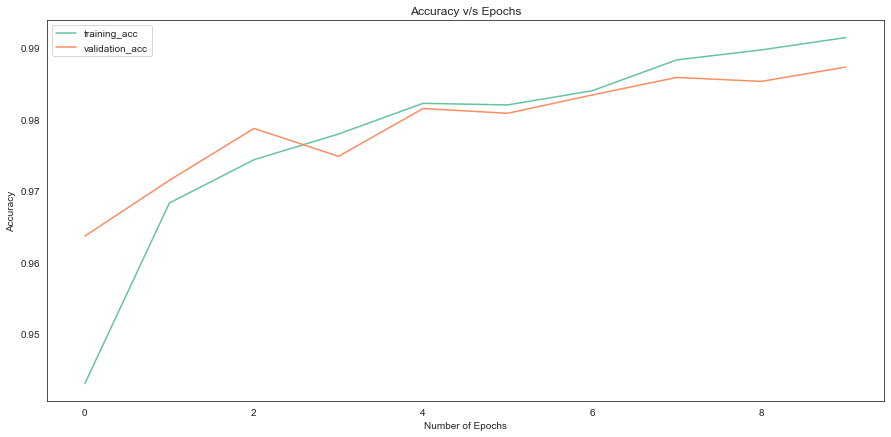

In [37]:
#plot accuracy
plt.figure(figsize=(15, 7))
plt.plot(range(epochs), history.history['accuracy'])
plt.plot(range(epochs), history.history['val_accuracy'])
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.legend(['training_acc', 'validation_acc'])
plt.title('Accuracy v/s Epochs')

In [38]:
train_lstm_results = lstm_model.evaluate(xtrain_pad, np.asarray(ytrain), verbose=0, batch_size=256)
test_lstm_results = lstm_model.evaluate(xtest_pad, np.asarray(ytest), verbose=0, batch_size=256)
print(f'Train accuracy: {train_lstm_results[1]*100:0.2f}')
print(f'Test accuracy: {test_lstm_results[1]*100:0.2f}')

Train accuracy: 99.40
Test accuracy: 98.73


# GRU model

### >First Layer -  Embedding layer that uses Vocabulary size of the GloVe vextor as length vectors to represent each word
### >Second Layer - GRU layer with 128 memory units ], return_sequence disabled to return the output.
### Third Layer - Dropout Layer for Regularization
### >Fourth Layer -  Dense output layer with a single neuron and a sigmoid activation function to make 0 or 1 predictions for the two classes.
### >Compilation Layer with loss function as 'binary_crossentropy' to classify the outputs into one of the two classes and optimizer as 'adam'.

In [39]:
emb_dim = embedding_matrix.shape[1]
gru_model = Sequential()
gru_model.add(Embedding(vocab_len, emb_dim, trainable = False, weights=[embedding_matrix]))
gru_model.add(GRU(128, return_sequences=False))
gru_model.add(Dropout(0.5))
gru_model.add(Dense(1, activation = 'sigmoid'))
gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(gru_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 100)         1000000   
                                                                 
 gru (GRU)                   (None, 128)               88320     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,088,449
Trainable params: 88,449
Non-trainable params: 1,000,000
_________________________________________________________________
None


In [40]:
batch_size = 256
epochs  = 10
history = gru_model.fit(xtrain_pad, np.asarray(ytrain), validation_data=(xtest_pad, np.asarray(ytest)), batch_size = batch_size, epochs = epochs)

Epoch 1/10
141/141 [==============================] - 134s 926ms/step - loss: 0.1874 - accuracy: 0.9213 - val_loss: 0.0959 - val_accuracy: 0.9651
Epoch 2/10
141/141 [==============================] - 132s 933ms/step - loss: 0.0903 - accuracy: 0.9677 - val_loss: 0.0823 - val_accuracy: 0.9719
Epoch 3/10
141/141 [==============================] - 134s 948ms/step - loss: 0.0738 - accuracy: 0.9746 - val_loss: 0.0664 - val_accuracy: 0.9783
Epoch 4/10
141/141 [==============================] - 137s 975ms/step - loss: 0.0596 - accuracy: 0.9783 - val_loss: 0.0626 - val_accuracy: 0.9794
Epoch 5/10
141/141 [==============================] - 144s 1s/step - loss: 0.0475 - accuracy: 0.9838 - val_loss: 0.0511 - val_accuracy: 0.9823
Epoch 6/10
141/141 [==============================] - 139s 989ms/step - loss: 0.0406 - accuracy: 0.9866 - val_loss: 0.0454 - val_accuracy: 0.9846
Epoch 7/10
141/141 [==============================] - 133s 944ms/step - loss: 0.0343 - accuracy: 0.9883 - val_loss: 0.0422 - va

Text(0.5, 1.0, 'Accuracy v/s Epochs')

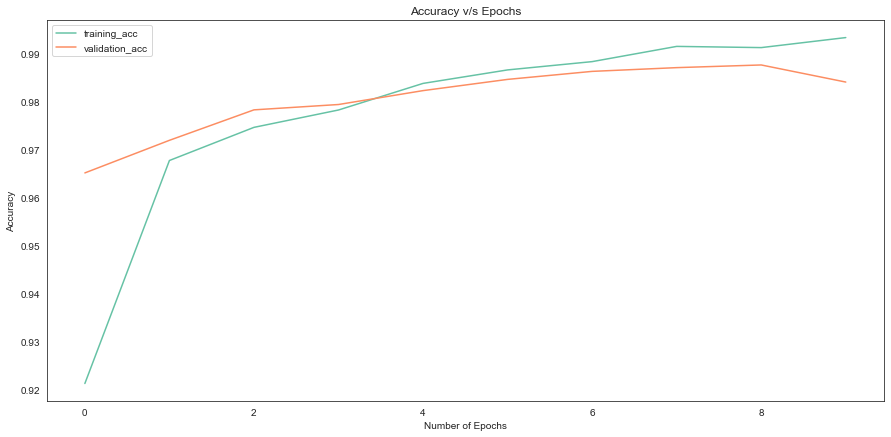

In [41]:
#plot accuracy
plt.figure(figsize=(15, 7))
plt.plot(range(epochs), history.history['accuracy'])
plt.plot(range(epochs), history.history['val_accuracy'])
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.legend(['training_acc', 'validation_acc'])
plt.title('Accuracy v/s Epochs')

In [42]:
train_gru_results = gru_model.evaluate(xtrain_pad, np.asarray(ytrain), verbose=0, batch_size=256)
test_gru_results = gru_model.evaluate(xtest_pad, np.asarray(ytest), verbose=0, batch_size=256)
print(f'Train accuracy: {train_gru_results[1]*100:0.2f}')
print(f'Test accuracy: {test_gru_results[1]*100:0.2f}')

Train accuracy: 99.06
Test accuracy: 98.41
